In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import scipy.stats as stats
import scikit_posthocs as sp
from itertools import combinations


In [99]:
# read csv
use = ['room_type', 'structure_type', 'price']

df = pd.read_csv('/Users/hyeom/Documents/GitHub/advanced_project/jiwon_project/csv_files/preprocessing_filtered.csv', usecols = use)

In [100]:
# --- 이상치 통계량 함수 ---

def outlier_stats(s):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    mask = (s < lower) | (s > upper)
    return pd.Series({'outlier_count': int(mask.sum()),'outlier_ratio': mask.mean()})

In [101]:
# -- 이상치 제거 함수 --
def remove_group_outliers(df: pd.DataFrame,
                          group_cols,
                          target_col: str = 'price',
                          iqr_multiplier: float = 1.5) -> pd.DataFrame:
    """
    각 그룹별(target_col) IQR 방식으로 이상치를 제거한 DataFrame을 반환합니다.

    Parameters
    ----------
    df : pd.DataFrame
        원본 DataFrame
    group_cols : str or list of str
        이상치 제거를 적용할 그룹 기준 컬럼명(들)
    target_col : str
        이상치 판정에 사용할 숫자형 컬럼명 (기본 'price')
    iqr_multiplier : float
        IQR 기준 배수 (기본 1.5)

    Returns
    -------
    pd.DataFrame
        이상치가 제거된 새로운 DataFrame (인덱스 재설정)
    """
    def _inlier_mask(s: pd.Series) -> pd.Series:
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - iqr_multiplier * iqr, q3 + iqr_multiplier * iqr
        return s.between(lower, upper)

    mask = df.groupby(group_cols)[target_col].transform(_inlier_mask)
    return df[mask].reset_index(drop=True)

# 사용 예시
# df = remove_group_outliers(df, ['room_type', 'structure_type'], 'price')

**room type 별로 price 이상치 확인하기**

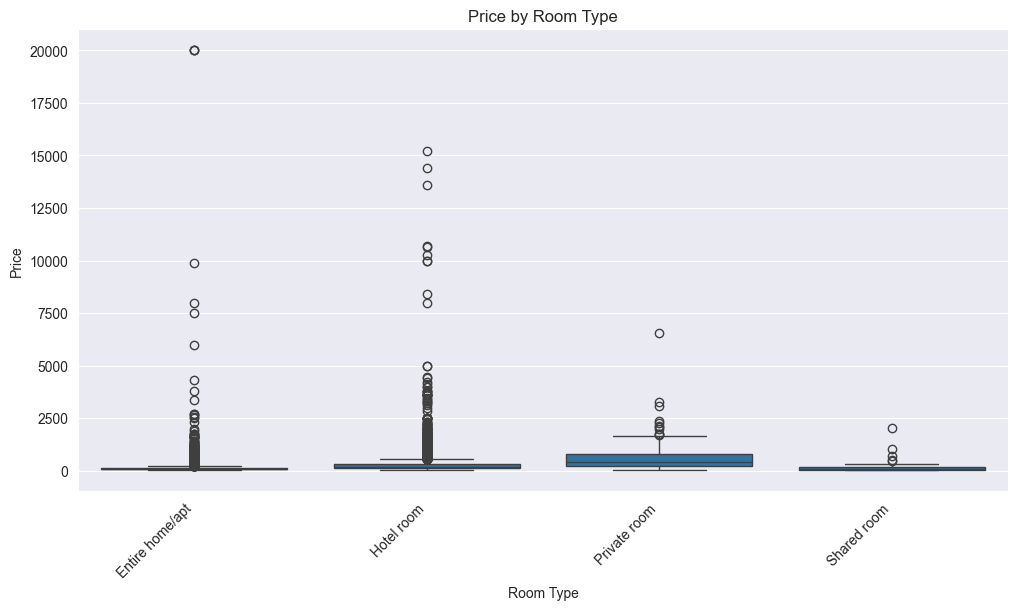

In [102]:
# --- room_type 별로 price 박스플롯
cat = df['room_type'].astype('category')
codes = cat.cat.codes
categories = cat.cat.categories

plt.figure(figsize=(12, 6))
sns.boxplot(
    x='room_type',
    y='price',
    data=df,
    showfliers=True       # ← 이상치(점) 표시 안 함
)

plt.xticks(range(len(categories)), categories, rotation=45, ha='right')
plt.title('Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()

In [103]:
# --- room type 별 price 이상치 ---
stats_type = df.groupby("room_type")['price'].apply(outlier_stats)

# 인덱스를 컬럼으로 올리기
stats_type = stats_type.reset_index()

# apply 결과를 MultiIndex → DataFrame 으로 펼치기
stats_type = (
    df.groupby("room_type")['price']
      .apply(outlier_stats)
      .unstack()              # outlier_count, outlier_ratio 가 각각 컬럼이 됨
      .reset_index()          # 구조를 DataFrame으로 완성
)

type_outlier_count = stats_type['outlier_count'].sum()
type_outlier_ratio = stats_type['outlier_count'].sum() / 22308


# 합계 확인
print("=== room type 별 price 이상치 ===")
print(f"전체 이상치 개수: {type_outlier_count}")
print(f"전체 이상치 비율: {type_outlier_ratio:.4f}")
print("\n=== room type 각 항목별 price 이상치 ===")
print(tabulate(stats_type, headers='keys', tablefmt='psql', showindex=False))

=== room type 별 price 이상치 ===
전체 이상치 개수: 1465.0
전체 이상치 비율: 0.0657

=== room type 각 항목별 price 이상치 ===
+-----------------+-----------------+-----------------+
| room_type       |   outlier_count |   outlier_ratio |
|-----------------+-----------------+-----------------|
| Entire home/apt |             729 |       0.0575648 |
| Hotel room      |              11 |       0.0295699 |
| Private room    |             720 |       0.0783801 |
| Shared room     |               5 |       0.0581395 |
+-----------------+-----------------+-----------------+


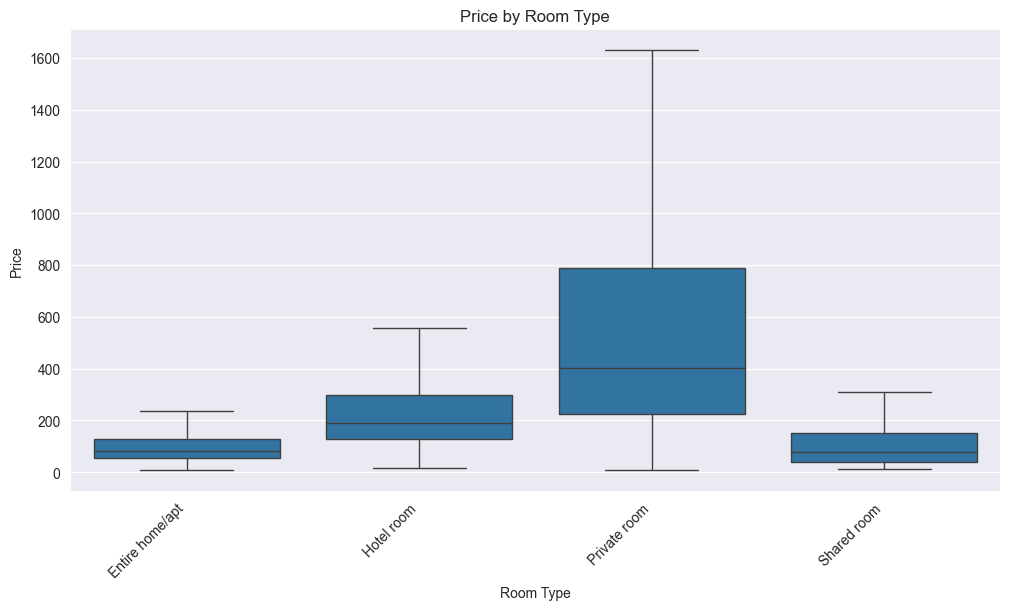

In [104]:
# --- room_type 별로 price 이상치 제거한 boxplot
cat = df['room_type'].astype('category')
codes = cat.cat.codes
categories = cat.cat.categories

plt.figure(figsize=(12, 6))
sns.boxplot(
    x='room_type',
    y='price',
    data=df,
    showfliers=False       # ← 이상치(점) 표시 안 함
)

plt.xticks(range(len(categories)), categories, rotation=45, ha='right')
plt.title('Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()

**structure type 별로 price 이상치 확인하기**

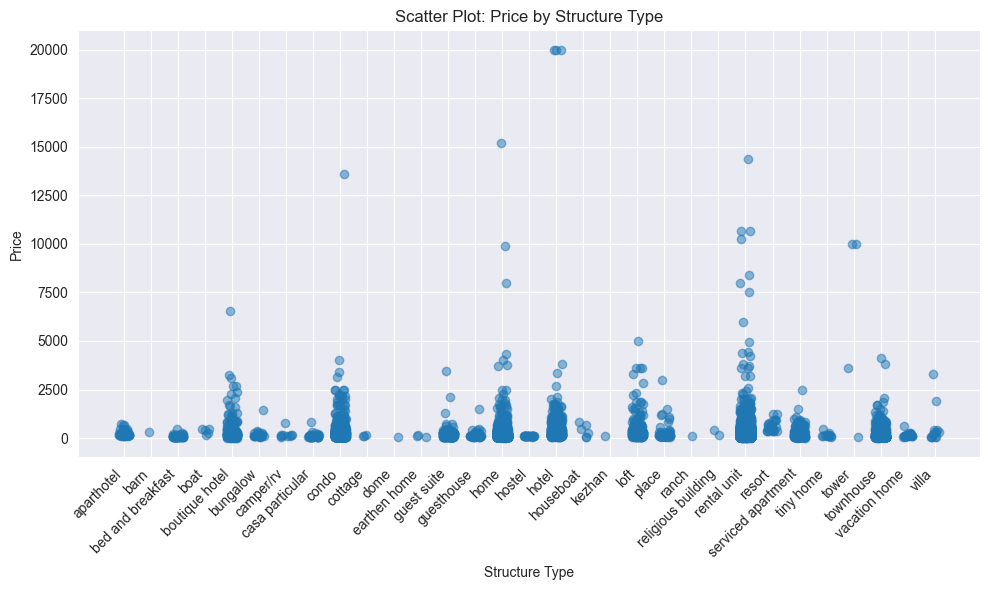

In [105]:
# --- structure_type 별로 price 산점도 ---
cat = df['structure_type'].astype('category')
codes = cat.cat.codes
categories = cat.cat.categories

# x축에 약간의 노이즈(jitter) 추가
jitter = np.random.uniform(-0.2, 0.2, size=len(df))
x = codes + jitter
y = df['price'].astype(float)

# 산점도
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)
plt.xticks(range(len(categories)), categories, rotation=45, ha='right')
plt.xlabel('Structure Type')
plt.ylabel('Price')
plt.title('Scatter Plot: Price by Structure Type')
plt.tight_layout()
plt.show()


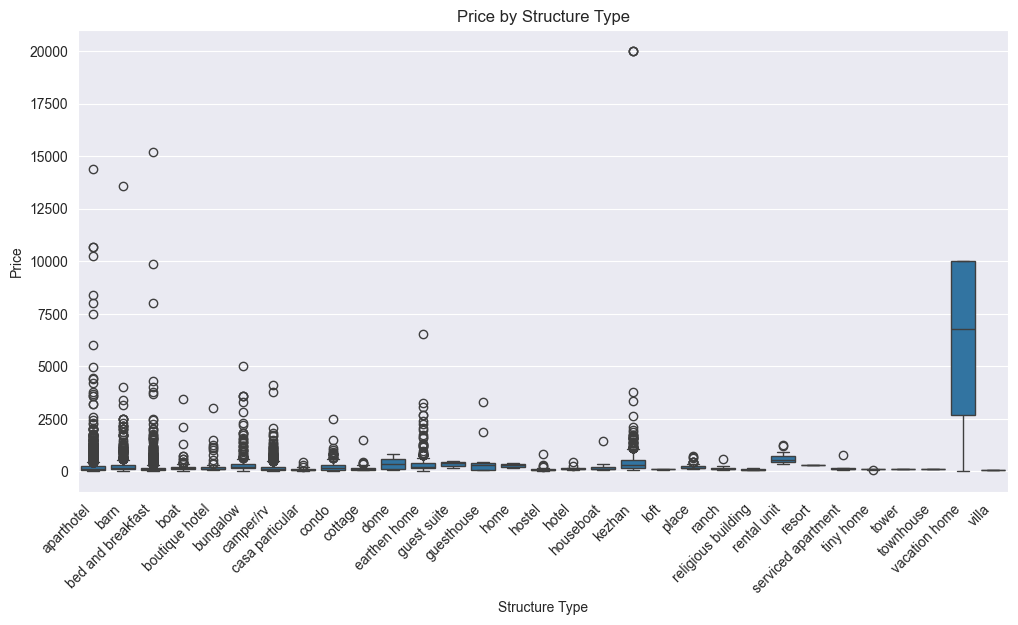

In [106]:
# --- structure_type 별로 price 박스플롯
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='structure_type',
    y='price',
    data=df,
    showfliers=True       # ← 이상치(점) 표시 안 함
)

plt.xticks(range(len(categories)), categories, rotation=45, ha='right')
plt.title('Price by Structure Type')
plt.xlabel('Structure Type')
plt.ylabel('Price')
plt.show()

In [107]:
# --- structure_type 별 price 이상치 ---
stats_type = df.groupby("structure_type")['price'].apply(outlier_stats)

# 인덱스를 컬럼으로 올리기
stats_type = stats_type.reset_index()

# apply 결과를 MultiIndex → DataFrame 으로 펼치기
stats_type = (
    df.groupby("structure_type")['price']
      .apply(outlier_stats)
      .unstack()              # outlier_count, outlier_ratio 가 각각 컬럼이 됨
      .reset_index()          # 구조를 DataFrame으로 완성
)

type_outlier_count = stats_type['outlier_count'].sum()
type_outlier_ratio = stats_type['outlier_count'].sum() / 22308


# 합계 확인
print("=== structure type 별 price 이상치 ===")
print(f"전체 이상치 개수: {type_outlier_count}")
print(f"전체 이상치 비율: {type_outlier_ratio:.4f}")
print("\n=== structure type 각 항목별 price 이상치 ===")
print(tabulate(stats_type, headers='keys', tablefmt='psql', showindex=False))

=== structure type 별 price 이상치 ===
전체 이상치 개수: 1372.0
전체 이상치 비율: 0.0615

=== structure type 각 항목별 price 이상치 ===
+--------------------+-----------------+-----------------+
| structure_type     |   outlier_count |   outlier_ratio |
|--------------------+-----------------+-----------------|
| aparthotel         |               8 |       0.140351  |
| barn               |               0 |       0         |
| bed and breakfast  |               3 |       0.05      |
| boat               |               0 |       0         |
| boutique hotel     |              35 |       0.165094  |
| bungalow           |               1 |       0.0454545 |
| camper/rv          |               1 |       0.111111  |
| casa particular    |               4 |       0.0909091 |
| condo              |              82 |       0.0791506 |
| cottage            |               0 |       0         |
| dome               |               0 |       0         |
| earthen home       |               0 |       0         |
| gu

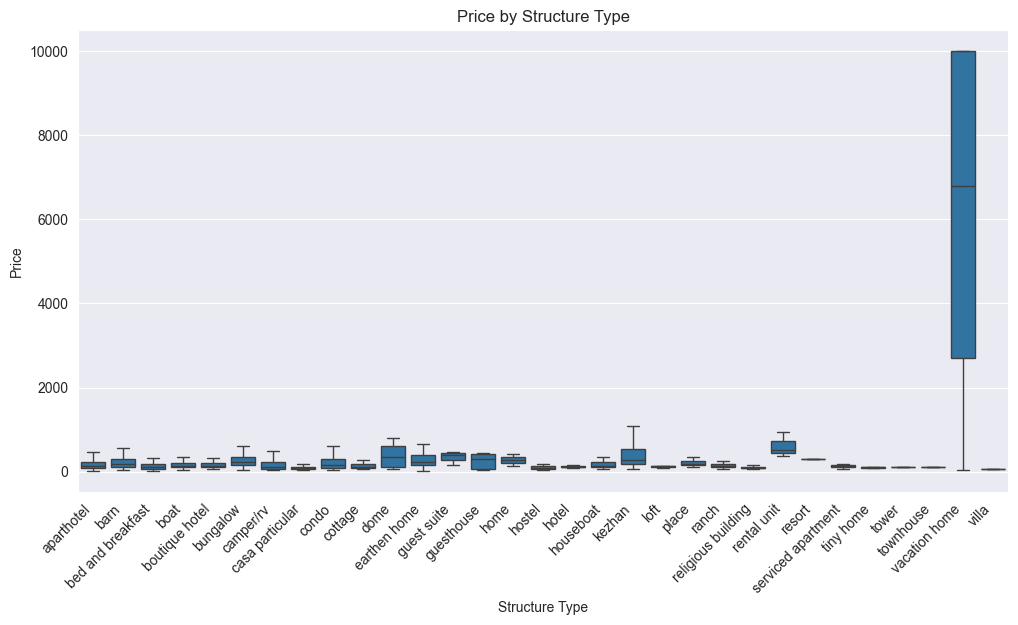

In [108]:
# --- structure_type 별로 price 박스플롯
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='structure_type',
    y='price',
    data=df,
    showfliers=False       # ← 이상치(점) 표시 안 함
)

plt.xticks(range(len(categories)), categories, rotation=45, ha='right')
plt.title('Price by Structure Type')
plt.xlabel('Structure Type')
plt.ylabel('Price')
plt.show()

**room type * structure_type 별로 price 이상치 확인하기**

In [109]:
# --- 'room_type' 별 'structure_type' 분포 확인하기 ---
df.groupby('room_type')['structure_type'].value_counts(normalize=True)

room_type        structure_type    
Entire home/apt  rental unit           0.761845
                 home                  0.083623
                 condo                 0.054564
                 townhouse             0.026532
                 loft                  0.022979
                 guest suite           0.021478
                 serviced apartment    0.011450
                 place                 0.004817
                 aparthotel            0.004185
                 guesthouse            0.003001
                 vacation home         0.001263
                 bungalow              0.001027
                 tiny home             0.000711
                 camper/rv             0.000632
                 villa                 0.000553
                 boat                  0.000395
                 houseboat             0.000316
                 tower                 0.000237
                 casa particular       0.000158
                 cottage               0.000158
    

In [110]:
# --- 'room_type' × 'structure_type'별 price 기술통계량 구하기 ---
stats = df.groupby(['room_type', 'structure_type'])['price'] \
          .describe() \
          .reset_index()

# - room_type별로 분리해서 출력
for room in df['room_type'].unique():
    print(f"\n=== {room} ===")
    sub = stats[stats['room_type'] == room] \
            .set_index('structure_type') \
            [['count','mean','std','min','25%','50%','75%','max']]
    print(tabulate(sub, headers='keys', tablefmt='psql'))


=== Private room ===
+--------------------+---------+----------+-----------+-------+--------+-------+--------+-------+
| structure_type     |   count |     mean |       std |   min |    25% |   50% |    75% |   max |
|--------------------+---------+----------+-----------+-------+--------+-------+--------+-------|
| aparthotel         |       4 | 348.5    |  276.701  |   110 | 176    | 274   | 446.5  |   736 |
| bed and breakfast  |      60 |  98.75   |   67.7064 |    36 |  56.5  |  78.5 | 111.5  |   446 |
| boutique hotel     |     142 | 295.549  |  385.17   |    55 | 145    | 193   | 270.75 |  2699 |
| bungalow           |       9 | 132.778  |   71.777  |    68 |  83    |  99   | 190    |   247 |
| camper/rv          |       1 | 100      |  nan      |   100 | 100    | 100   | 100    |   100 |
| casa particular    |      41 | 118.732  |  125.977  |    40 |  67    |  87   | 120    |   826 |
| condo              |     341 | 147.953  |  155.031  |    28 |  72    | 119   | 171    |  2291 

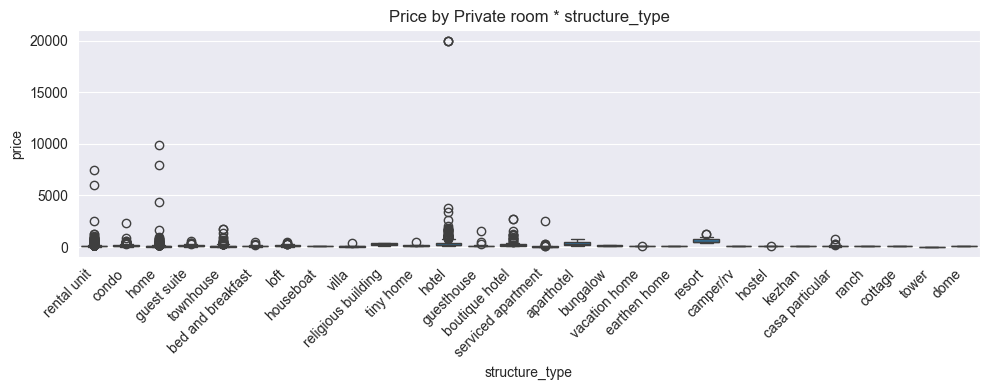

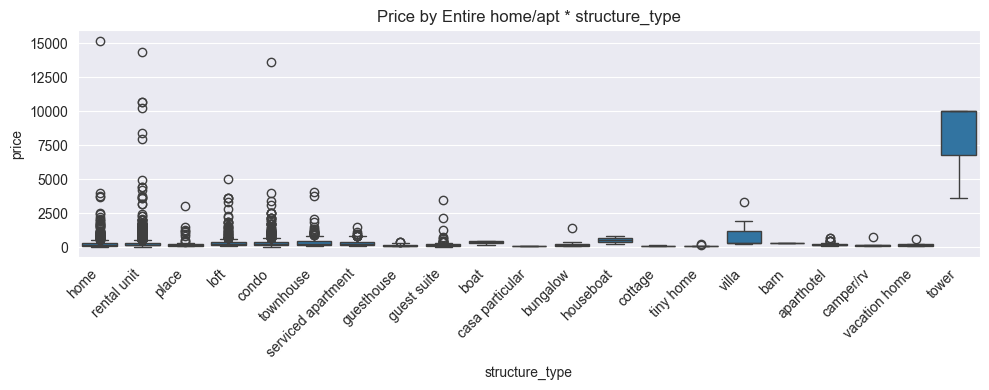

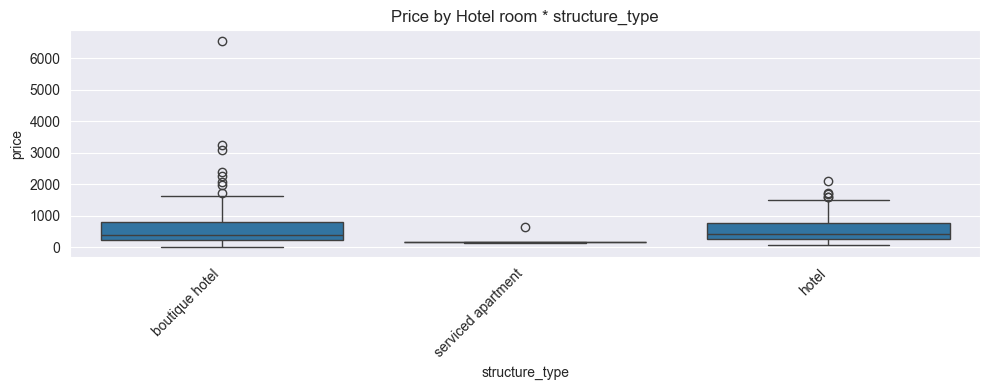

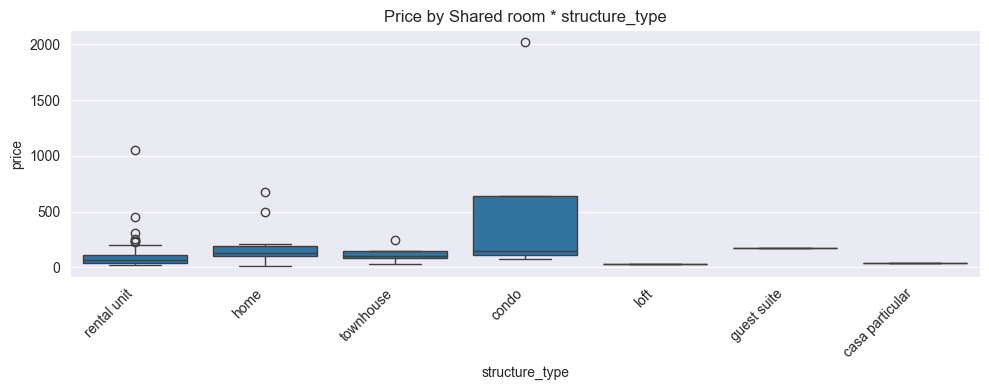

In [111]:
# --- room_type별로 분리해서 시각화 ---
for room in df['room_type'].unique():
    plt.figure(figsize=(10,4))
    sns.boxplot(x='structure_type', y='price',
                data=df[df['room_type']==room],
                showfliers=True )                   # outlier
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Price by {room} * structure_type")
    plt.tight_layout()
    plt.show()

In [112]:
# --- room_type * structure_type 별 price 이상치 ---
stats_room_type = df.groupby(["room_type", "structure_type"])['price'].apply(outlier_stats)

# 인덱스를 컬럼으로 올리기
stats_room_type = stats_room_type.reset_index()

# apply 결과를 MultiIndex → DataFrame 으로 펼치기
stats_room_type = (
    df.groupby(["room_type", "structure_type"])['price']
      .apply(outlier_stats)
      .unstack()              # outlier_count, outlier_ratio 가 각각 컬럼이 됨
      .reset_index()          # 구조를 DataFrame으로 완성
)

room_type_outlier_count = stats_room_type['outlier_count'].sum()
room_type_outlier_ratio = stats_room_type['outlier_count'].sum() / 22308


# 합계 확인
print("=== room type * structure type 별 price 이상치 ===")
print(f"전체 이상치 개수: {room_type_outlier_count}")
print(f"전체 이상치 비율: {room_type_outlier_ratio:.4f}")
print("\n=== room type * structure type 각 항목별 price 이상치 ===")
print(tabulate(stats_room_type, headers='keys', tablefmt='psql', showindex=False))

=== room type * structure type 별 price 이상치 ===
전체 이상치 개수: 1357.0
전체 이상치 비율: 0.0608

=== room type * structure type 각 항목별 price 이상치 ===
+-----------------+--------------------+-----------------+-----------------+
| room_type       | structure_type     |   outlier_count |   outlier_ratio |
|-----------------+--------------------+-----------------+-----------------|
| Entire home/apt | aparthotel         |               7 |       0.132075  |
| Entire home/apt | barn               |               0 |       0         |
| Entire home/apt | boat               |               0 |       0         |
| Entire home/apt | bungalow           |               1 |       0.0769231 |
| Entire home/apt | camper/rv          |               1 |       0.125     |
| Entire home/apt | casa particular    |               0 |       0         |
| Entire home/apt | condo              |              64 |       0.0926194 |
| Entire home/apt | cottage            |               0 |       0         |
| Entire home/apt 

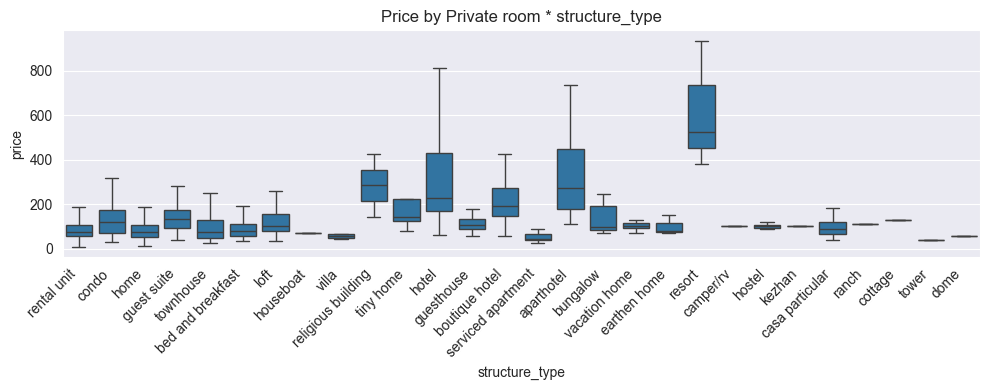

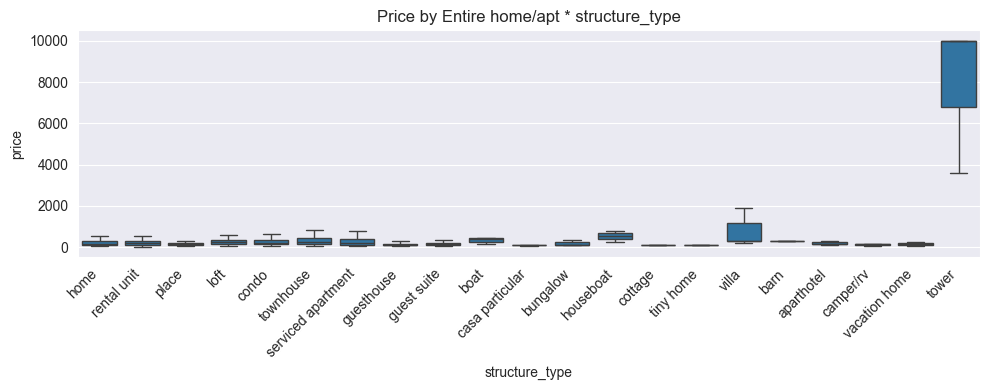

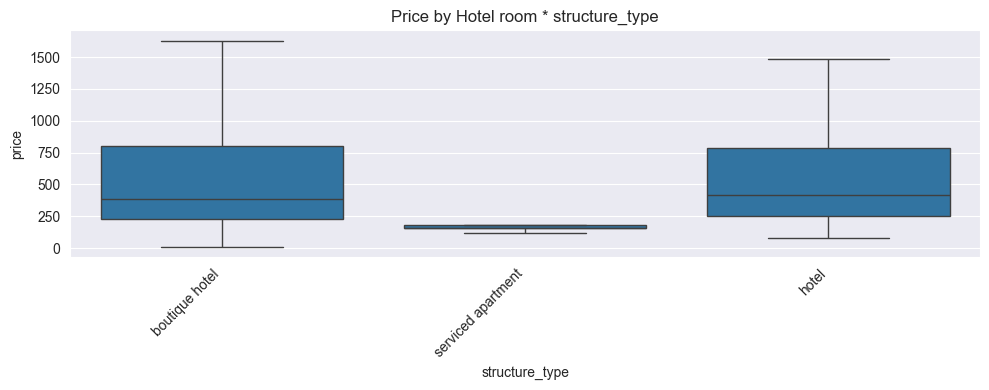

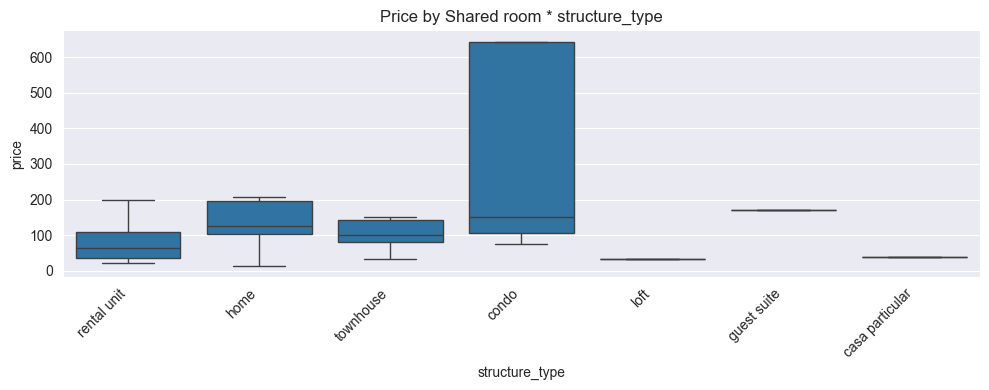

In [113]:
# --- room_type별로 분리해서 시각화 ---
for room in df['room_type'].unique():
    plt.figure(figsize=(10,4))
    sns.boxplot(x='structure_type', y='price',
                data=df[df['room_type']==room],
                showfliers=False )                   # outlier
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Price by {room} * structure_type")
    plt.tight_layout()
    plt.show()

**이상치 제거하기**

In [115]:
# df = remove_group_outliers(df, 'room_type', 'price')
# df = remove_group_outliers(df, 'structure_type', 'price')
df = remove_group_outliers(df, ['room_type', 'structure_type'], 'price')

In [119]:
# --- 이상치 제거 이후 'room_type' 별 price 기술통계량 구하기 ---
stats = df.groupby('room_type')['price'] \
          .describe() \
          .reset_index()

sub = stats.set_index('room_type')[['count','mean','std','min','25%','50%','75%','max']]

print(f"=== room_type ===")
print(tabulate(sub, headers='keys', tablefmt='psql', showindex=True))

=== room_type ===
+-----------------+---------+----------+----------+-------+-------+-------+-------+-------+
| room_type       |   count |     mean |      std |   min |   25% |   50% |   75% |   max |
|-----------------+---------+----------+----------+-------+-------+-------+-------+-------|
| Entire home/apt |   11993 | 215.456  | 174.432  |    16 |   125 |   180 | 276   | 10000 |
| Hotel room      |     358 | 457      | 295.169  |     8 |   222 |   394 | 721   |  1629 |
| Private room    |    8525 |  96.7037 |  75.6975 |     7 |    55 |    78 | 113   |   934 |
| Shared room     |      75 |  83.1333 |  53.428  |    14 |    37 |    67 | 111.5 |   206 |
+-----------------+---------+----------+----------+-------+-------+-------+-------+-------+


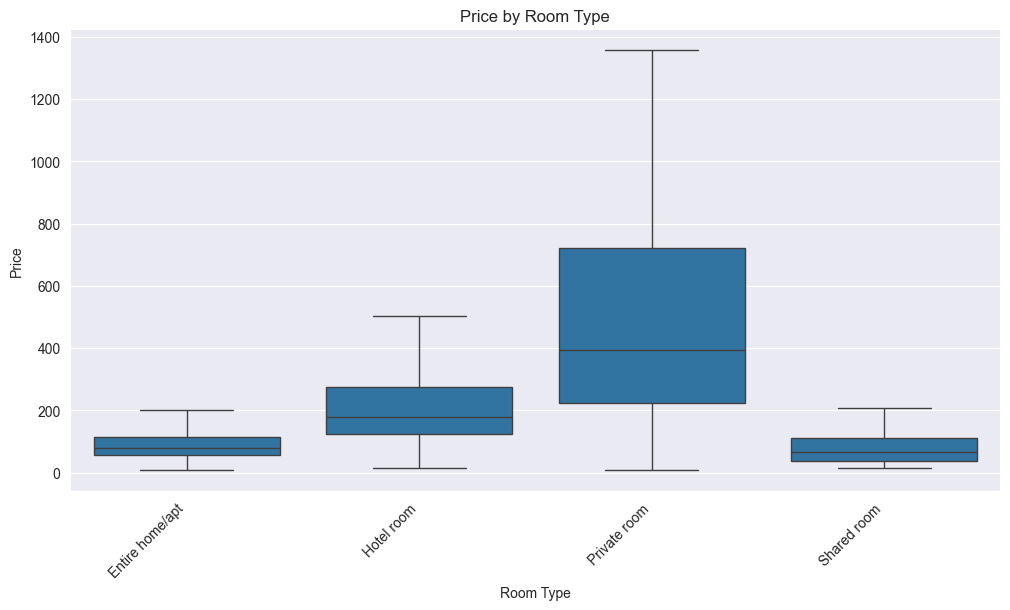

In [120]:
cat = df['room_type'].astype('category')
codes = cat.cat.codes
categories = cat.cat.categories

plt.figure(figsize=(12, 6))
sns.boxplot(
    x='room_type',
    y='price',
    data=df,
    showfliers=False       # ← 이상치(점) 표시 안 함
)

plt.xticks(range(len(categories)), categories, rotation=45, ha='right')
plt.title('Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()

In [116]:
# --- 이상치 제거 이후 'room_type' × 'structure_type'별 price 기술통계량 구하기 ---
stats = df.groupby(['room_type', 'structure_type'])['price'] \
          .describe() \
          .reset_index()

# - room_type별로 분리해서 출력
for room in df['room_type'].unique():
    print(f"\n=== {room} ===")
    sub = stats[stats['room_type'] == room] \
            .set_index('structure_type') \
            [['count','mean','std','min','25%','50%','75%','max']]
    print(tabulate(sub, headers='keys', tablefmt='psql'))


=== Private room ===
+--------------------+---------+----------+-----------+-------+--------+-------+--------+-------+
| structure_type     |   count |     mean |       std |   min |    25% |   50% |    75% |   max |
|--------------------+---------+----------+-----------+-------+--------+-------+--------+-------|
| aparthotel         |       4 | 348.5    | 276.701   |   110 | 176    | 274   | 446.5  |   736 |
| bed and breakfast  |      57 |  87.2281 |  40.6817  |    36 |  55    |  75   | 108    |   191 |
| boutique hotel     |     126 | 186.873  |  83.582   |    55 | 126    | 184.5 | 232.5  |   425 |
| bungalow           |       9 | 132.778  |  71.777   |    68 |  83    |  99   | 190    |   247 |
| camper/rv          |       1 | 100      | nan       |   100 | 100    | 100   | 100    |   100 |
| casa particular    |      37 |  88.2703 |  33.0207  |    40 |  65    |  80   | 106    |   180 |
| condo              |     323 | 124.17   |  64.731   |    28 |  69.5  | 115   | 163    |   316 

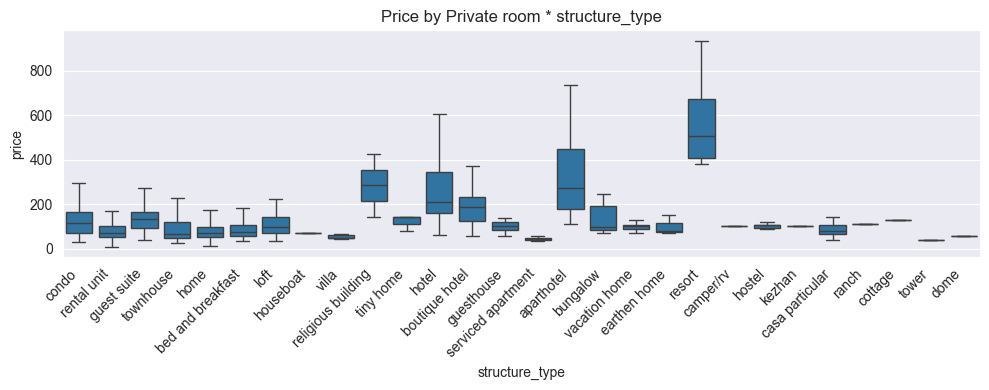

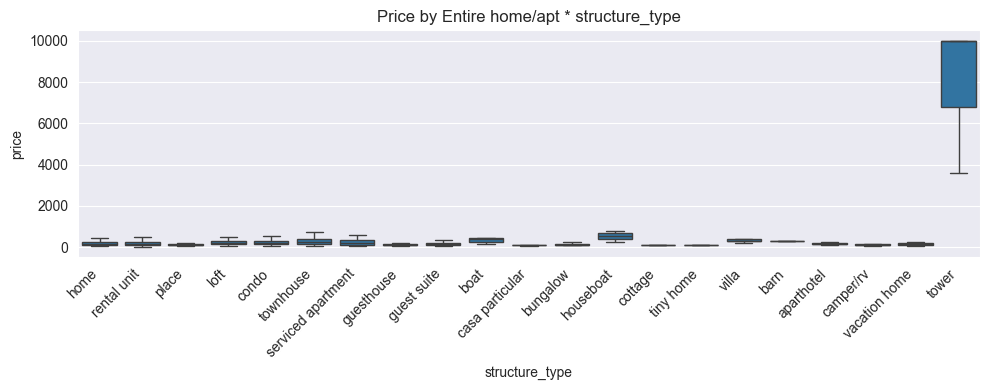

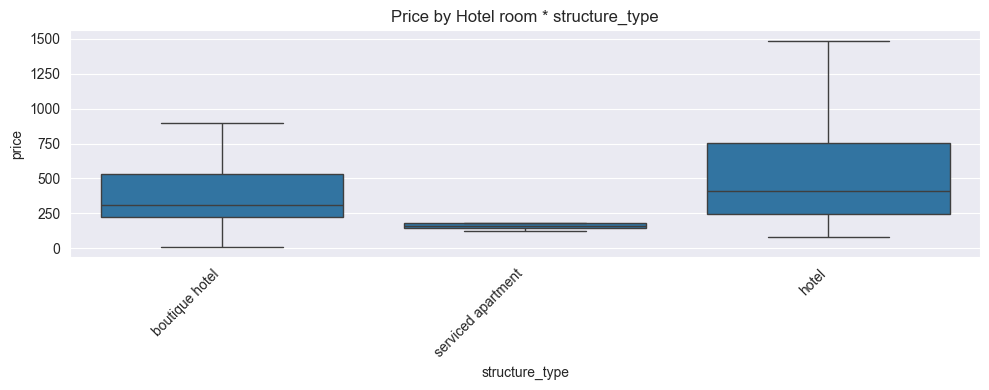

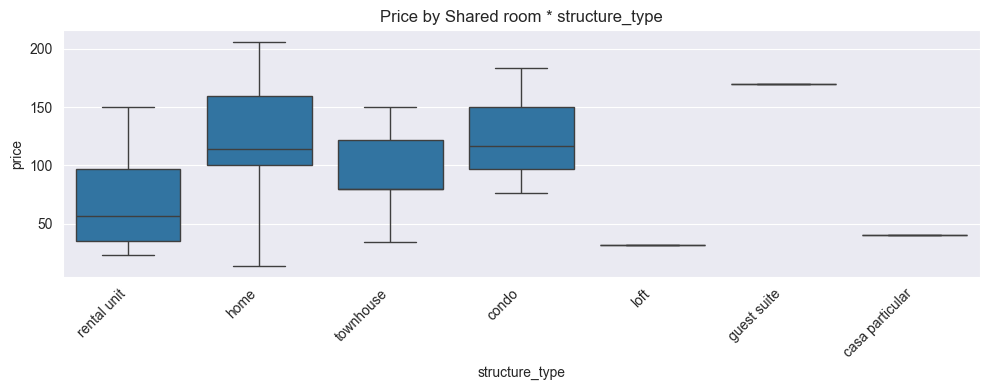

In [121]:
# --- room_type별로 분리해서 시각화 ---
for room in df['room_type'].unique():
    plt.figure(figsize=(10,4))
    sns.boxplot(x='structure_type', y='price',
                data=df[df['room_type']==room],
                showfliers=False )                   # outlier
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Price by {room} * structure_type")
    plt.tight_layout()
    plt.show()

**price 분포별로 structure category 새롭게 제안**

In [125]:
# --- 가격대 분위수에 따라 카테고리 생성하기

df['structure_category'] = pd.qcut(
    df['price'],
    q=4,
    labels=['Q1','Q2','Q3','Q4']
)


# 분위수별 개수
vc = df['structure_category'] \
       .value_counts() \
       .sort_index() \
       .reset_index()
vc.columns = ['structure_category','count']

print("\n=== 분위수별 개수 ===")
print(tabulate(
    vc,
    headers='keys',
    tablefmt='psql',
    showindex=False
))

# 4) room_type × 분위수별 분포
sub = df.groupby(['room_type','structure_category']) \
        .size() \
        .unstack(fill_value=0)

print("\n=== room_type × structure_category 분포 ===")
print(tabulate(
    sub,
    headers='keys',
    tablefmt='psql',
    showindex=True
))



=== 분위수별 개수 ===
+----------------------+---------+
| structure_category   |   count |
|----------------------+---------|
| Q1                   |    5263 |
| Q2                   |    5248 |
| Q3                   |    5204 |
| Q4                   |    5236 |
+----------------------+---------+

=== room_type × structure_category 분포 ===
+-----------------+------+------+------+------+
| room_type       |   Q1 |   Q2 |   Q3 |   Q4 |
|-----------------+------+------+------+------|
| Entire home/apt |  601 | 2828 | 3958 | 4606 |
| Hotel room      |    8 |   23 |   55 |  272 |
| Private room    | 4609 | 2381 | 1177 |  358 |
| Shared room     |   45 |   16 |   14 |    0 |
+-----------------+------+------+------+------+


/var/folders/y0/671x56056fg565s3792l4vnr0000gn/T/ipykernel_44452/1762923924.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sub = df.groupby(['room_type','structure_category']) \


In [160]:
# --- EDA ---
# room type 과 price 비교이므로 세 집단 이상 검정 -> ANOVA 사용
h0 = '귀무가설: 네 개의 room_type과 price 평균간의 차이가 없을 것이다.'
h1 = '대립가설: 적어도 한 쌍의 room_type 종류에 따라 price 간의 차이가 있을 것이다.'

groups = [ df.loc[df.room_type==g, 'price'] for g in df['room_type'].unique() ]
print("=== 정규성, 등분산성 검정 ===")

# - 정규성 검정 (shapiro 검정 사용)
# 귀무가설: 데이터가 정규분포를 따른다
for grp in groups:
    sh_stat, sh_p = stats.shapiro(grp)
    print(f'정규성 Shapiro p-value = {sh_p:.4f}')

# - 등분산성 검정
# 귀무가설: 데이터간 분산은 같다
le_stat, le_p = stats.levene(*groups)
print(f'등분산성 Levene p-value = {le_p:.4f}')

if (sh_p >= 0.05) & (le_p >= 0.05) :
    print('\nshapiro p-value >= 0.05로 정규성을 만족한다.')
    print('levene p-value >= 0.05로 등분산성을 만족한다.')
    print('\n따라서 ANOVA 검정을 진행한다.')

elif (sh_p >= 0.05) & (le_p < 0.05) :
    print('\nshapiro p-value >= 0.05로 정규성을 만족한다.')
    print('levene p-value < 0.05로 등분산성을 만족하지 않는다.')
    print('\n따라서 몰루?')

elif (sh_p < 0.05) & (le_p >= 0.05) :
    print('\nshapiro p-value < 0.05로 정규성을 만족하지 않는다.')
    print('levene p-value >= 0.05로 등분산성을 만족한다.')
    print('\n따라서 몰루?.')

elif (sh_p < 0.05) & (le_p < 0.05):
    print('\nshapiro p-value < 0.05로 정규성을 만족하지 않는다.')
    print('levene p-value < 0.05로 등분산성을 만족하지 않는다.')
    print('\n따라서 ANOVA의 대안검정인 Kruskal-Wallis 검정을 진행한다.')

    print("\n=== Kruskal-Wallis 검정 ===")

    # - 정규성과 등분산성 모두 만족하지 않기 때문에 ANOVA의 대안 검정인 Kruskal-Wallis 검정 방법을 사용한다.

    groups = [df.loc[df.room_type==g, 'price'] for g in ['Private room','Entire home/apt','Hotel room','Shared room']]
    H, p = stats.kruskal(*groups)
    print(f"H={H:.4f}, p-value={p:.4f}")

    if  p < 0.05:
        print(h0)
        print(h1)
        print('p-value < 0.05로 귀무가설을 기각하며 사후검정을 진행하여 어떤 그룹간 차이가 있는지 확인한다.')

        print("\n=== bonferroni 사후 검정 ===")

        # - bonferroni 사후검정을 진행하여 어떤 그룹간 차이가 있는지 확인한다
        pvals = sp.posthoc_dunn(df, val_col='price', group_col='room_type', p_adjust='bonferroni').round(4)

        print(tabulate(pvals, headers='keys', tablefmt='psql', showindex=True, floatfmt=".4f"))

        # 유의미한 차이가 있는/없는 그룹 자동 판별
        alpha = 0.05
        sig = []      # 유의미한 차이(p < alpha)
        not_sig = []  # 유의미하지 않은 차이(p >= alpha)

        for g1, g2 in combinations(pvals.index, 2):
            p = pvals.loc[g1, g2]
            if p < alpha:
                sig.append((g1, g2, p))
            else:
                not_sig.append((g1, g2, p))

        # 사후검정 결과 출력
        print("\n=== 유의미한 차이가 있는 그룹 쌍 (p < 0.05) ===")
        for g1, g2, p in sig:
            print(f"- {g1} vs {g2}: p = {p:.4f}")

        print("\n=== 유의미한 차이가 없는 그룹 쌍 (p ≥ 0.05) ===")
        for g1, g2, p in not_sig:
            print(f"- {g1} vs {g2}: p = {p:.4f}")

    else:
        print(h0)
        print(h1)
        print('p-value가 0.05보다 크므로 귀무가설을 채택한다.')

=== 정규성, 등분산성 검정 ===
정규성 Shapiro p-value = 0.0000
정규성 Shapiro p-value = 0.0000
정규성 Shapiro p-value = 0.0000
정규성 Shapiro p-value = 0.0000
등분산성 Levene p-value = 0.0000

shapiro p-value < 0.05로 정규성을 만족하지 않는다.
levene p-value < 0.05로 등분산성을 만족하지 않는다.

따라서 ANOVA의 대안검정인 Kruskal-Wallis 검정을 진행한다.

=== Kruskal-Wallis 검정 ===
H=8354.8940, p-value=0.0000
귀무가설: 네 개의 room_type과 price 평균간의 차이가 없을 것이다.
대립가설: 적어도 한 쌍의 room_type 종류에 따라 price 간의 차이가 있을 것이다.
p-value < 0.05로 귀무가설을 기각하며 사후검정을 진행하여 어떤 그룹간 차이가 있는지 확인한다.

=== bonferroni 사후 검정 ===
+-----------------+-------------------+--------------+----------------+---------------+
|                 |   Entire home/apt |   Hotel room |   Private room |   Shared room |
|-----------------+-------------------+--------------+----------------+---------------|
| Entire home/apt |            1.0000 |       0.0000 |         0.0000 |        0.0000 |
| Hotel room      |            0.0000 |       1.0000 |         0.0000 |        0.0000 |
| Private room    |            0.0

/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8525.
  res = hypotest_fun_out(*samples, **kwds)
/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11993.
  res = hypotest_fun_out(*samples, **kwds)


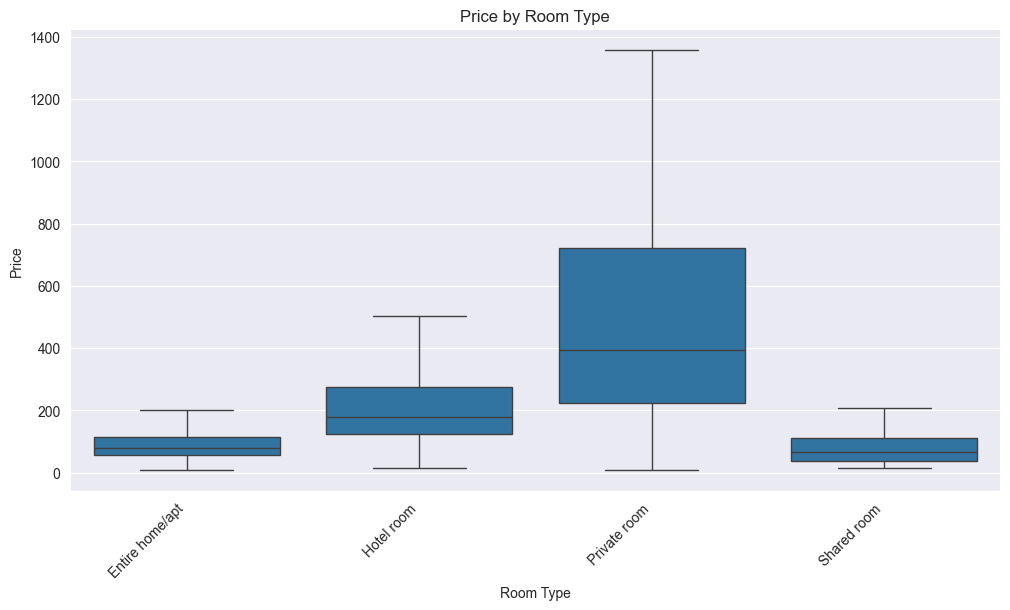

In [178]:
cat = df['room_type'].astype('category')
codes = cat.cat.codes
categories = cat.cat.categories

plt.figure(figsize=(12, 6))
sns.boxplot(
    x='room_type',
    y='price',
    data=df,
    showfliers=False       # ← 이상치(점) 표시 안 함
)

plt.xticks(range(len(categories)), categories, rotation=45, ha='right')
plt.title('Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()

In [153]:
df['room_type'].eq('Shared room').agg(count='sum', ratio='mean')

count    75.00000
ratio     0.00358
Name: room_type, dtype: float64

In [154]:
df['room_type'].eq('Private room').agg(count='sum', ratio='mean')


count    8525.000000
ratio       0.406902
Name: room_type, dtype: float64

In [155]:
df['room_type'].eq('Hotel room').agg(count='sum', ratio='mean')


count    358.000000
ratio      0.017087
Name: room_type, dtype: float64

In [156]:
df['room_type'].eq('Entire home/apt').agg(count='sum', ratio='mean')

count    11993.000000
ratio        0.572431
Name: room_type, dtype: float64

In [171]:
# --- EDA2 ---
# structure type 과 price 비교이므로 세 집단 이상 검정 -> ANOVA 사용
h0 = '귀무가설: 모든 structure_type과 price 평균간의 차이가 없을 것이다.'
h1 = '대립가설: 적어도 한 쌍의 structure_type 종류에 따라 price 간의 차이가 있을 것이다.'

# shapiro 검정 전 개수가 3개 이하인 컬럼은 필터링 진행
counts = df['structure_type'].value_counts()
valid = counts[counts >= 3].index
df_filtered = df[df['structure_type'].isin(valid)]

groups = [df_filtered.loc[df_filtered.structure_type==g, 'price'] for g in df_filtered['structure_type'].unique() ]
print("=== 정규성, 등분산성 검정 ===")

# - 정규성 검정 (shapiro 검정 사용)
# 귀무가설: 데이터가 정규분포를 따른다
shapiro_ps = []
for g in df_filtered['structure_type'].unique():
    grp = df_filtered.loc[df_filtered.structure_type == g, 'price']
    stat, p = stats.shapiro(grp)
    shapiro_ps.append(p)
    # print(f"{g}: Shapiro p = {p:.4f}")

normality = all(p >= 0.05 for p in shapiro_ps)
# print("▶ 전체 정규성 가정 만족?", normality)

# - 등분산성 검정
# 귀무가설: 데이터간 분산은 같다
le_stat, le_p = stats.levene(*[
    df_filtered.loc[df_filtered.structure_type == g, 'price']
    for g in df_filtered['structure_type'].unique()
])
print(f'등분산성 Levene p-value = {le_p:.4f}')

if normality and le_p >= 0.05:
    print('\nshapiro p-value >= 0.05로 정규성을 만족한다.')
    print('levene p-value >= 0.05로 등분산성을 만족한다.')
    print('\n따라서 ANOVA 검정을 진행한다.')

elif normality and le_p < 0.05:
    print('\nshapiro p-value >= 0.05로 정규성을 만족한다.')
    print('levene p-value < 0.05로 등분산성을 만족하지 않는다.')
    print('\n따라서 Welch ANOVA 검정을 진행한다.')

elif not normality and le_p >= 0.05:
    print('\nshapiro p-value < 0.05로 정규성을 만족하지 않는다.')
    print('levene p-value >= 0.05로 등분산성을 만족한다.')
    print('\n따라서 비모수 검정 or 데이터 변환을 진행한다.')

else:
    print('\nshapiro p-value < 0.05로 정규성을 만족하지 않는다.')
    print('levene p-value < 0.05로 등분산성을 만족하지 않는다.')
    print('\n따라서 ANOVA의 대안검정인 Kruskal-Wallis 검정을 진행한다.')

    print("\n=== Kruskal-Wallis 검정 ===")

    # - 정규성과 등분산성 모두 만족하지 않기 때문에 ANOVA의 대안 검정인 Kruskal-Wallis 검정 방법을 사용한다.

    groups = [df_filtered.loc[df_filtered.structure_type==g, 'price'] for g in
        ['condo', 'home', 'rental unit', 'guest suite', 'place', 'loft',
       'townhouse', 'bed and breakfast', 'serviced apartment',
       'guesthouse', 'houseboat', 'boutique hotel', 'boat', 'villa',
       'casa particular', 'tiny home', 'bungalow', 'hotel', 'cottage',
       'aparthotel', 'vacation home', 'earthen home', 'resort',
       'camper/rv', 'hostel', 'tower']]

    H, p = stats.kruskal(*groups)
    print(f"H={H:.4f}, p-value={p:.4f}")

    if  p < 0.05:
        print(h0)
        print(h1)
        print('p-value < 0.05로 귀무가설을 기각하며 사후검정을 진행하여 어떤 그룹간 차이가 있는지 확인한다.')

        print("\n=== bonferroni 사후 검정 ===")

        # - bonferroni 사후검정을 진행하여 어떤 그룹간 차이가 있는지 확인한다
        pvals = sp.posthoc_dunn(df_filtered, val_col='price', group_col='structure_type', p_adjust='bonferroni').round(4)

        print(tabulate(pvals, headers='keys', tablefmt='psql', showindex=True, floatfmt=".4f"))

        # 유의미한 차이가 있는/없는 그룹 자동 판별
        alpha = 0.05
        sig = []      # 유의미한 차이(p < alpha)
        not_sig = []  # 유의미하지 않은 차이(p >= alpha)

        for g1, g2 in combinations(pvals.index, 2):
            p = pvals.loc[g1, g2]
            if p < alpha:
                sig.append((g1, g2, p))
            else:
                not_sig.append((g1, g2, p))

        sig_df = pd.DataFrame(sig, columns=['Group1','Group2','p-value'])
        not_sig_df = pd.DataFrame(not_sig, columns=['Group1','Group2','p-value'])

        # 유의미한 차이가 있는 그룹 쌍
        print("\n=== 유의미한 차이가 있는 그룹 쌍 (p < 0.05) ===")
        print(tabulate(
            sig_df,
            headers='keys',
            tablefmt='psql',
            showindex=False,
            floatfmt=".4f"
        ))

        # 유의미한 차이가 없는 그룹 쌍
        print("\n=== 유의미한 차이가 없는 그룹 쌍 (p ≥ 0.05) ===")
        print(tabulate(
            not_sig_df,
            headers='keys',
            tablefmt='psql',
            showindex=False,
            floatfmt=".4f"
        ))

    else:
        print(h0)
        print(h1)
        print('p-value가 0.05보다 크므로 귀무가설을 채택한다.')

=== 정규성, 등분산성 검정 ===
등분산성 Levene p-value = 0.0000

shapiro p-value < 0.05로 정규성을 만족하지 않는다.
levene p-value < 0.05로 등분산성을 만족하지 않는다.

따라서 ANOVA의 대안검정인 Kruskal-Wallis 검정을 진행한다.

=== Kruskal-Wallis 검정 ===
H=1755.0705, p-value=0.0000
귀무가설: 모든 structure_type과 price 평균간의 차이가 없을 것이다.
대립가설: 적어도 한 쌍의 structure_type 종류에 따라 price 간의 차이가 있을 것이다.
p-value < 0.05로 귀무가설을 기각하며 사후검정을 진행하여 어떤 그룹간 차이가 있는지 확인한다.

=== bonferroni 사후 검정 ===
+--------------------+--------------+---------------------+--------+------------------+------------+-------------+-------------------+---------+-----------+----------------+---------------+--------------+--------+----------+---------+-------------+--------+---------+---------------+----------+----------------------+-------------+---------+-------------+-----------------+---------+
|                    |   aparthotel |   bed and breakfast |   boat |   boutique hotel |   bungalow |   camper/rv |   casa particular |   condo |   cottage |   earthen home |   guest suite |   guesth

/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14139.
  res = hypotest_fun_out(*samples, **kwds)


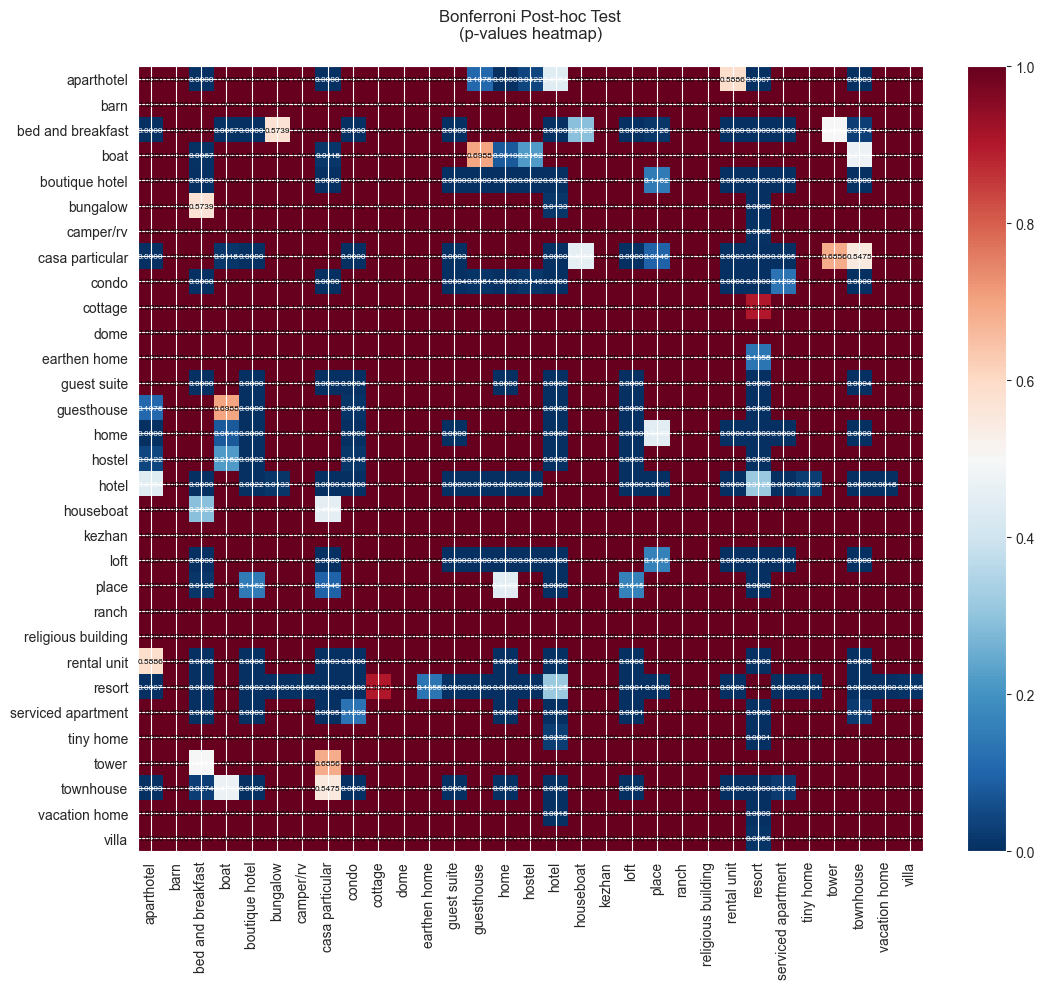

In [175]:
import scikit_posthocs as sp
import matplotlib.pyplot as plt

# 1) Bonferroni 사후검정 p-value 계산 (이미 kruskal 혹은 ANOVA 후 귀무기각된 상태여야 합니다)
pvals = sp.posthoc_dunn(
    df,
    val_col='price',
    group_col='structure_type',
    p_adjust='bonferroni'
).round(4)

# 2) 행·열 레이블과 매트릭스 값 추출
labels = pvals.index.tolist()
matrix = pvals.values

# 3) 히트맵 그리기
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(
    matrix,
    cmap='RdBu_r',          # 파랑(1.0) ↔ 베이지(0.0)
    vmin=0.0, vmax=1.0      # p-value 범위
)

# 4) 축 눈금 및 레이블 설정
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, ha='center')
ax.set_yticklabels(labels)

# 5) 각 셀 위에 p-value 숫자 표시
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(
            j, i,
            f"{matrix[i, j]:.4f}",
            ha='center', va='center',
            fontsize=6,
            color='black' if matrix[i,j]>0.5 else 'white'
        )

# 6) 컬러바와 제목
fig.colorbar(cax, fraction=0.046, pad=0.04)
plt.title("Bonferroni Post-hoc Test\n(p-values heatmap)", pad=20)
plt.tight_layout()
plt.show()


In [177]:
# structure type만 반영해도 될까? room type도 반영해야할까?

# 1) structure_type별 요약
struct_stats = df.groupby('structure_type')['price'] \
                 .agg(mean='mean', median='median', std='std', count='count')

# 2) room_type＋structure_type별 요약
combo_stats = df.groupby(['structure_type','room_type'])['price'] \
                .agg(mean='mean', median='median', std='std', count='count') \
                .reset_index()

# 3) 같은 structure_type 안에서 room_type별 평균·중앙값 최소/최대 차이 계산
range_stats = (
    combo_stats
      .groupby('structure_type')
      .agg(mean_min=('mean','min'), mean_max=('mean','max'),
           median_min=('median','min'), median_max=('median','max'))
)
range_stats['mean_diff']   = range_stats['mean_max'] - range_stats['mean_min']
range_stats['median_diff'] = range_stats['median_max'] - range_stats['median_min']

# 4) 최종 테이블: structure_type 단독 요약 + 내부 차이
summary = struct_stats.join(range_stats[['mean_diff','median_diff']])

# 5) diff 기준 검토용 컬럼 추가
summary['mean_diff_lt_std']      = summary['mean_diff'] < summary['std']
summary['median_diff_lt_std']    = summary['median_diff'] < summary['std']
summary['mean_diff_pct']         = summary['mean_diff'] / summary['mean']
summary['median_diff_pct']       = summary['median_diff'] / summary['median']
summary['mean_diff_lt_10pct']    = summary['mean_diff_pct'] < 0.10
summary['median_diff_lt_10pct']  = summary['median_diff_pct'] < 0.10

# 6) 보고 싶은 컬럼 순서대로 정리
cols = [
    'mean','median','std','count',
    'mean_diff','median_diff',
    'mean_diff_lt_std','median_diff_lt_std',
    'mean_diff_pct','median_diff_pct',
    'mean_diff_lt_10pct','median_diff_lt_10pct'
]
summary = summary[cols]

# 7) 예쁘게 출력
print(tabulate(
    summary.sort_values('mean', ascending=False),
    headers='keys',
    tablefmt='psql',
    floatfmt=(".2f",)*4 + (".2f",)*2 + ("",)*2 + (".2%",)*2 + ("",)*2
))


+--------------------+---------+----------+---------+---------+-------------+---------------+--------------------+----------------------+-----------------+---------------------+----------------------+------------------------+
| structure_type     |    mean |   median |     std |   count |   mean_diff |   median_diff | mean_diff_lt_std   | median_diff_lt_std   |   mean_diff_pct |     median_diff_pct | mean_diff_lt_10pct   | median_diff_lt_10pct   |
|--------------------+---------+----------+---------+---------+-------------+---------------+--------------------+----------------------+-----------------+---------------------+----------------------+------------------------|
| tower              | 5910.00 |  6800.00 | 4941.30 |       4 |     7826.67 |        9960.0 | False              | False                |         132.43% | 1.464705882352941   | False                | False                  |
| resort             |  570.50 |   508.00 |  187.45 |      26 |        0.00 |           0.0 | Tr